In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from logistics import new_cav_model , J_analytical_new, fourier_transform_matrix, fast_f_t, spectrum_1
from logistics_exact_cavity import Driven_cavity_class,two_modes_cavity
from numpy.fft import fft,fftfreq
from scipy.interpolate import interp1d	
from matplotlib import gridspec

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.size'] = 14  


In [2]:
data = np.load("data_spectrum.npz")
data_phi=data['data_phi']
data_any=data['data_any']

phi_values = np.linspace(0,2*np.pi,100)
gamma_values = np.linspace(0.05,200,300)


w_any =data_any[0][0]
u_map_any = np.asarray( [data[1] for data in data_any])

w_phi = np.asarray(data_phi)[0][0]
u_map_phi = np.asarray( [data[1] for data in data_phi])

In [3]:
def average_fft(x, y, Ms):
	spectra = []
	freqs_list = []

	for M in Ms:
		omega, A = fast_f_t(x, y, M)
		freqs_list.append(omega)
		spectra.append(A)

	omega_min = max(freqs[0] for freqs in freqs_list)     # límite inferior común
	omega_max = min(freqs[-1] for freqs in freqs_list)    # límite superior común
	N_common = max(len(f) for f in freqs_list)            # densidad similar a la mayor
	omega_common = np.linspace(omega_min, omega_max, N_common)


	spectra_interp = []
	for omega, A in zip(freqs_list, spectra):
		f_interp = interp1d(omega, A, kind='linear', bounds_error=False, fill_value=0.0)
		spectra_interp.append(f_interp(omega_common))

	A_avg = np.mean(spectra_interp, axis=0)

	return omega_common, A_avg

def run_simulation(gamma,tau,phi,t_max,dt,initial=[1,0]):
	cav = new_cav_model(gamma,phi,tau,0)
	cav.evolve(t_max,dt)
	t,e = cav.excited_state(initial)
	a_out_eff = cav.a_out_array[:,2] 			# this is only valid for single excitation
	npoints_default = np.arange(4000,4101,1)	# range number of points in the fourier transform to average
	w,u = average_fft(t,a_out_eff,npoints_default) 
	return t,e,w,u

from joblib import Parallel, delayed

def paralelizar(parameter_list,f,ncores: int = 5):
	resultados = Parallel(n_jobs=ncores, backend='loky')(
		delayed(f)(param) for param in parameter_list
	)
	return resultados


# ----------- many mode exact Jaynes-Cummings --------------------

from dataclasses import dataclass, field
from scipy.linalg import expm

def mkron(A, *args):
	if len(args) == 0:
		return A
	return np.kron(A, mkron(args[0], *args[1:]))

def b_op(i: int, n: int) -> np.ndarray:
	''' generator of sigma^{-}_{i} operators in the initial state (standard pauli matrices times the identity)'''
	return mkron(np.eye(2**i), [[0, 0], [1, 0]], np.eye(2 ** (n - i - 1))).astype(np.complex128)

@dataclass
class Nmode_cavity:
	omega_qubit :float  = 1 
	coupling: float = 1 
	modes_frequencies:np.ndarray = field(default_factory=lambda: np.array([]))
	Hamiltonian: np.ndarray = field(init=False) 
	psi0: np.ndarray = field(init=False) 
	
	def __post_init__(self):
		N = len(self.modes_frequencies)
		self.Hamiltonian = np.zeros((N+1,N+1),dtype=complex)
		self.Hamiltonian[0,0] = self.omega_qubit
		for n in range(N):
			self.Hamiltonian[n+1,n+1] = self.modes_frequencies[n]
			self.Hamiltonian[n+1,0] = self.coupling
			self.Hamiltonian[0,n+1] = self.coupling
		self.psi0 = np.zeros(len(self.modes_frequencies)+1,dtype=complex)
		self.psi0[0] = 1
	def evolve(self,times):
		vec=[] 
		for t in times:
			U = expm(-1j*self.Hamiltonian*t)
			vec.append(U@self.psi0)
		return np.asarray(vec)
		
		
def FRS(N,tau):
	return  np.arange(-2*(N-1),2*(N+1),2)*np.pi/tau 

def err_est(t,y1,y2): 
	t = np.asarray(t)
	y1 = np.asarray(y1)
	y2 = np.asarray(y2)

	integrand = np.sqrt(np.abs(y1**2 - y2**2))
	integral = np.trapezoid(integrand, t)
	t_max = t[-1] - t[0]

	return integral / t_max

# 0. Spectrum as a function of time 

I want to meake sure the spectrum does not do crazy stuff before long t 

In [13]:
gamma = 1
phi = 2*np.pi 
tau = 1 
dt = tau/100

t_max_values = np.linspace(20,150,70)*tau
M_flatten = np.arange(4000,4101,1)    # you need to make sure you have enough points to interpolate, fixing t_max/dt > Npoints


def sample_t_max_M(t_max_value): 
	gamma_sample = 0.05
	tau_sample = 1
	phi_sample = 2*np.pi
	dt = tau_sample/100
	model = new_cav_model(gamma_sample,phi_sample,tau_sample)
	model.evolve(t_max_value,dt)
	t,_ = model.excited_state([1,0])
	a_out_flat = model.a_out_array[:,2]
	w,u = average_fft(t,a_out_flat,M_flatten)
	return w,u

def sample_t_max_NM(t_max_value): 
	gamma_sample = 200
	tau_sample = 1
	phi_sample = 2*np.pi
	dt = tau_sample/100
	model = new_cav_model(gamma_sample,phi_sample,tau_sample)
	model.evolve(t_max_value,dt)
	t,_ = model.excited_state([1,0])
	a_out_flat = model.a_out_array[:,2]
	w,u = average_fft(t,a_out_flat,M_flatten)
	return w,u

In [14]:
data_tiempo_M = paralelizar(t_max_values,sample_t_max_M)
w_tiempo_M =  np.asarray([data[0] for data in data_tiempo_M])
u_tiempo_M = np.asarray([data[1] for data in data_tiempo_M])
w_ref_M = w_tiempo_M[-1]
u_interp_M = []
for n in range(u_tiempo_M.shape[0]):
    interp = interp1d(w_tiempo_M[n],u_tiempo_M[n])
    u_interp_M.append(interp(w_ref_M))
u_interp_M = np.asarray(u_interp_M)

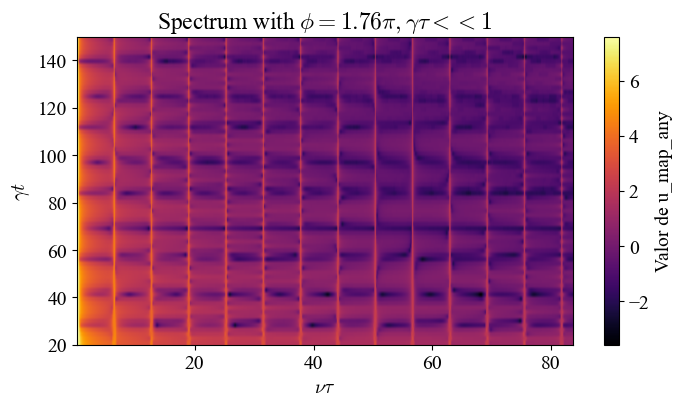

In [16]:
map_u_tiempo =u_interp_M[:,1:]
tau_s = 1
gamma_s= 1 
plt.figure(figsize=(8, 4))
plt.imshow(np.log(map_u_tiempo),
		    cmap='inferno',
			origin='lower',
			extent= [w_ref_M[2]*tau_s,w_ref_M[-1]*tau_s,gamma_s*t_max_values[0],gamma_s*t_max_values[-1]],
			aspect='auto')
plt.colorbar(label='Valor de u_map_any')
plt.title(r'Spectrum with $\phi = 1.76 \pi , \gamma \tau << 1 $')
plt.xlabel(r"$\nu \tau $")
plt.ylabel(r"$\gamma t $")

plt.show()

In [6]:
data_tiempo_NM = paralelizar(t_max_values,sample_t_max_NM)
w_tiempo_NM =  np.asarray([data[0] for data in data_tiempo_NM])
u_tiempo_NM = np.asarray([data[1] for data in data_tiempo_NM])
w_ref_NM = w_tiempo_NM[-1]
u_interp_NM = []
for n in range(u_tiempo_NM.shape[0]):
    interp = interp1d(w_tiempo_NM[n],u_tiempo_NM[n])
    u_interp_NM.append(interp(w_ref_NM))
u_interp_NM = np.asarray(u_interp_NM)

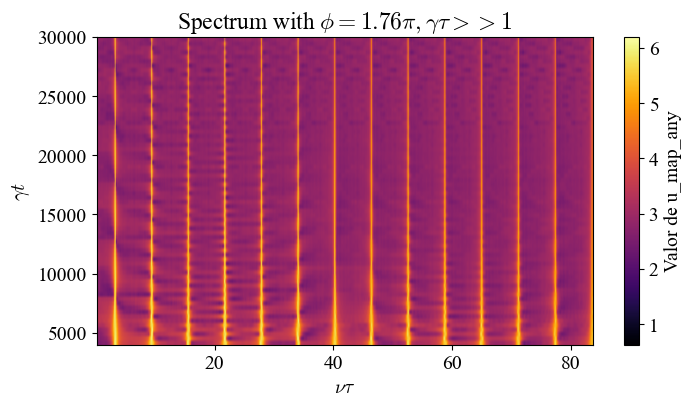

In [11]:
map_u_tiempo =u_interp_NM[:,1:]
tau_s = 1
gamma_s= 200 
plt.figure(figsize=(8, 4))
plt.imshow(np.log(map_u_tiempo),
		    cmap='inferno',
			origin='lower',
			extent= [w_ref_NM[2]*tau_s,w_ref_NM[-1]*tau_s,gamma_s*t_max_values[0],gamma_s*t_max_values[-1]],
			aspect='auto')
plt.colorbar(label='Valor de u_map_any')
plt.title(r'Spectrum with $\phi = 1.76 \pi , \gamma \tau >> 1 $')
plt.xlabel(r"$\nu \tau $")
plt.ylabel(r"$\gamma t $")

plt.show()

# 1. Spectrum as a function of $ \gamma \tau $ 

I want to see that the spectrum does whwen increasing $\gamma \tau$. In order to avoid coincidences, I pick 'strange' values of  $\{ \phi, \gamma,\tau \}$ 

In [77]:
map_plot_2 = u_map_any[:,1:]
phi_s = 1.76*np.pi
tau_s = 0.8

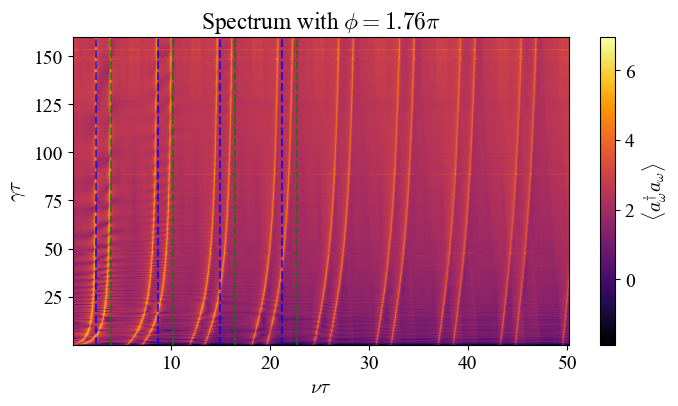

In [85]:
plt.figure(figsize=(8, 4))
plt.imshow(np.log(map_plot_2), cmap='inferno', origin='lower',extent= [w_any[1]*tau_s, w_any[-1]*tau_s, gamma_values[0]*tau_s, gamma_values[-1]*tau_s],aspect='auto')
plt.colorbar(label=r"$\langle a_{\omega}^{\dag}a_{\omega} \rangle $")
plt.title(r'Spectrum with $\phi = 1.76 \pi$')
plt.xlabel(r"$\nu \tau $")
plt.ylabel(r"$\gamma \tau $")
for n in range(0,4):
	plt.axvline((2*n-1)*np.pi+phi_s,linestyle='--',color='b',alpha=0.7)
	plt.axvline((2*n+3)*np.pi-phi_s,linestyle='--',color='g',alpha=0.7)

plt.show()

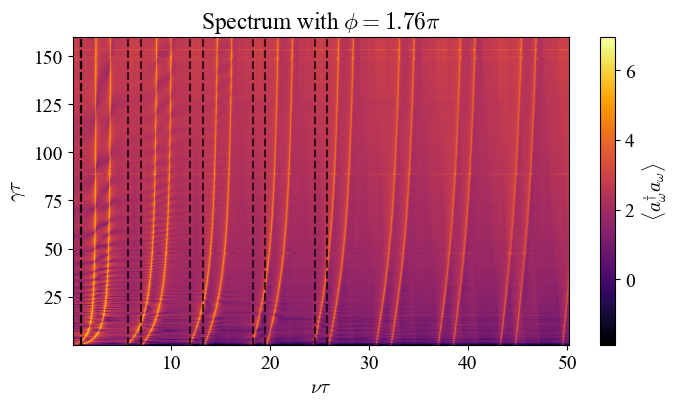

In [86]:
plt.figure(figsize=(8, 4))
plt.imshow(np.log(map_plot_2), cmap='inferno', origin='lower',extent= [w_any[1]*tau_s, w_any[-1]*tau_s, gamma_values[0]*tau_s, gamma_values[-1]*tau_s],aspect='auto')
plt.colorbar(label=r"$\langle a_{\omega}^{\dag}a_{\omega} \rangle $")
plt.title(r'Spectrum with $\phi = 1.76 \pi$')
plt.xlabel(r"$\nu \tau $")
plt.ylabel(r"$\gamma \tau $")
for n in range(0,4):
	plt.axvline(2*n*np.pi+phi_s/tau_s,linestyle='--',color='k',alpha=0.7)
	plt.axvline((2*n+4)*np.pi-phi_s/tau_s,linestyle='--',color='k',alpha=0.7)
	plt.axvline(np.sqrt(tau_s),linestyle='--',color='k',alpha=0.7)
plt.show()

# 2. Spectrum as a function of $\phi$ with $\gamma \tau <<1 $

In [4]:
M_flatten = np.arange(4000,4101,1)

def sample_phi_Markov(phi_value):
	gamma_sample=0.02
	tau_sample = 1
	t_max = 200*tau_sample
	dt = tau_sample/100
	model = new_cav_model(gamma_sample,phi_value,tau_sample)
	model.evolve(t_max,dt)
	t,_ = model.excited_state([1,0])
	a_out_flat = model.a_out_array[:,2]
	w,u = average_fft(t,a_out_flat,M_flatten)
	return w,u

In [64]:
# calculations 
phi_values = np.linspace(0,2*np.pi,100) # I took tau = 1 for this one 

data_phi_M = paralelizar(phi_values,sample_phi_Markov)
w_phi_M = np.asarray(data_phi_M)
u_map_phi_M = np.asarray( [data[1] for data in data_phi_M])
w=w_phi_M[0,0,:]

gamma = 1.4
tau = 0.034
t_max = 200*tau
dt = tau/100

phi_1 = np.pi 
phi_2 = 2*np.pi 
phi_3 = 0.4*np.pi 

cav = new_cav_model(gamma,phi_1,tau,0)
cav.evolve(t_max,dt)
t1,e1 = cav.excited_state([1,0])
a_out_eff = cav.a_out_array[:,2] 			# this is only valid for single excitation
npoints_default = np.arange(4000,4101,1)	# range number of points in the fourier transform to average
w1,u1 = average_fft(t1,a_out_eff,npoints_default) 

exact = Nmode_cavity(phi_1/tau,np.sqrt(gamma/tau),FRS(1,tau))
pe1=np.abs(exact.evolve(t1)[:,0]**2)  


cav = new_cav_model(gamma,phi_2,tau,0)
cav.evolve(t_max,dt)
t2,e2 = cav.excited_state([1,0])
a_out_eff = cav.a_out_array[:,2] 			# this is only valid for single excitation
npoints_default = np.arange(4000,4101,1)	# range number of points in the fourier transform to average
w2,u2 = average_fft(t2,a_out_eff,npoints_default) 

exact = Nmode_cavity(phi_2/tau,np.sqrt(gamma/tau),FRS(1,tau))
pe2=np.abs(exact.evolve(t1)[:,0]**2)  

cav = new_cav_model(gamma,phi_3,tau,0)
cav.evolve(t_max,dt)
t3,e3 = cav.excited_state([1,0])
a_out_eff = cav.a_out_array[:,2] 			# this is only valid for single excitation
npoints_default = np.arange(4000,4101,1)	# range number of points in the fourier transform to average
w3,u3 = average_fft(t2,a_out_eff,npoints_default) 

exact = Nmode_cavity(phi_3/tau,np.sqrt(gamma/tau),FRS(1,tau))
pe3=np.abs(exact.evolve(t3)[:,0]**2) 


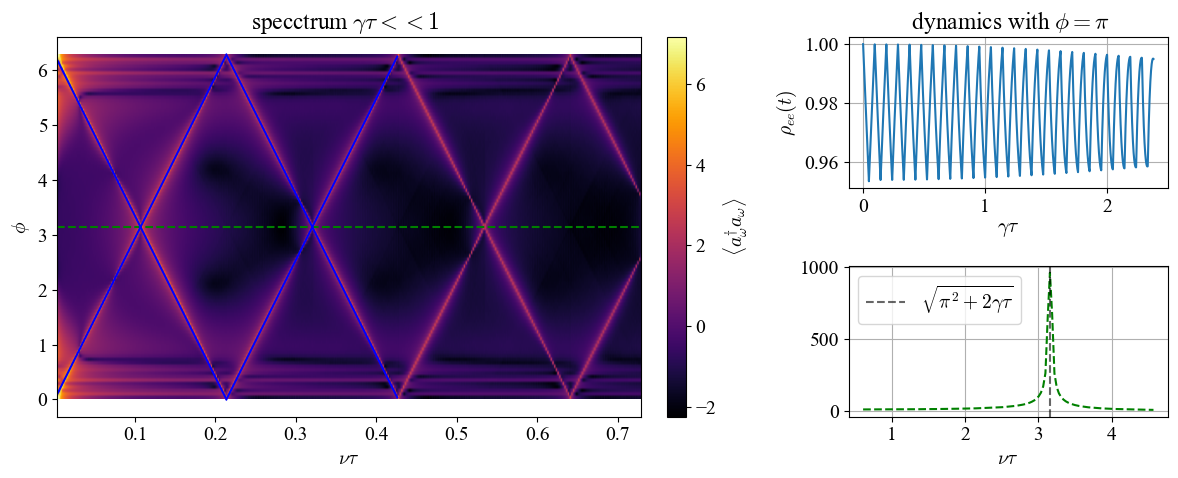

In [87]:
map_plot = u_map_phi_M[:,3:700]  # not showing all the frequencies, but could. 
gamma_s = 1.4
tau_s = 0.034
fig = plt.figure(figsize=(12, 5))

gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], figure=fig)

#-------------------
ax_heat = fig.add_subplot(gs[:, 0])
im = ax_heat.imshow(
	np.log(map_plot),
	origin='lower',
	aspect='auto',
	extent=[w[3]*tau_s, w[700]*tau_s,phi_values[0], phi_values[-1]],
	cmap='inferno'
)
ax_heat.set_xlabel(r'$  \nu \tau   $')
ax_heat.set_ylabel(r"$ \phi $")
ax_heat.set_title(r'specctrum $ \gamma \tau << 1  $  ')
ax_heat.axhline(np.pi,linestyle = '--',color='g')

cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
cbar.set_label(label=r"$\langle a_{\omega}^{\dag}a_{\omega} \rangle $")
#--------------------  
ax_top = fig.add_subplot(gs[0, 1])
ax_top.plot(gamma*t1[0:5000],e1[0:5000])
ax_top.grid()
ax_top.set_xlabel(r"$\gamma \tau$")
ax_top.set_ylabel(r"$ \rho_{ee}(t)$")
ax_top.set_title(r" dynamics with $\phi = \pi $")
#--------------------
ax_bottom = fig.add_subplot(gs[1, 1])
ax_bottom.plot(tau*w1[20:150],u1[20:150],'g--')
ax_bottom.axvline(np.sqrt(np.pi**2+2*gamma_s*tau),linestyle='--',color='k',alpha=0.6,label =r"$ \sqrt{\pi^{2}+2\gamma\tau}$")
ax_bottom.legend()
ax_bottom.set_xlabel(r"$\nu \tau $")
ax_bottom.grid()

ax_heat.plot(w[3:205]*tau_s,w[3:205],'b')
ax_heat.plot(w[3:205]*tau_s,2*np.pi-w[3:205],'b')
ax_heat.plot(w[205:2*205]*tau_s,-2*np.pi+w[205:2*205],'b')
ax_heat.plot(w[205:2*205]*tau_s,4*np.pi-w[205:2*205],'b')


plt.tight_layout()
plt.show()

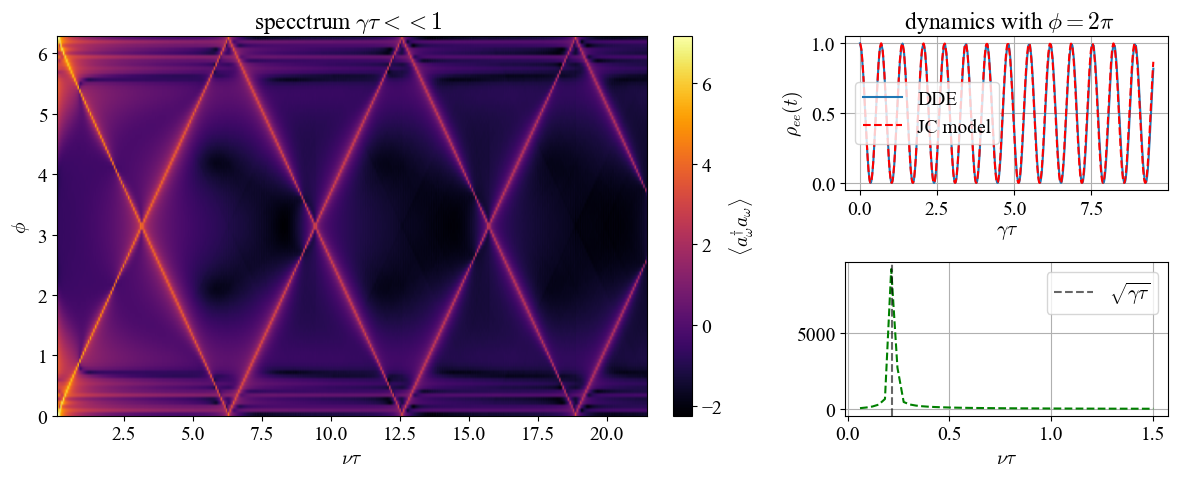

In [88]:
map_plot = u_map_phi_M[:,3:700]  # not showing all the frequencies, but could. 
tau_s = 1
fig = plt.figure(figsize=(12, 5))

gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], figure=fig)

#-------------------
ax_heat = fig.add_subplot(gs[:, 0])
im = ax_heat.imshow(
	np.log(map_plot),
	origin='lower',
	aspect='auto',
	extent=[w[3]*tau_s, w[700]*tau_s,phi_values[0], phi_values[-1]],
	cmap='inferno'
)
ax_heat.set_xlabel(r'$  \nu \tau   $')
ax_heat.set_ylabel(r"$ \phi $")
ax_heat.set_title(r'specctrum $ \gamma \tau << 1  $  ')
ax_heat.axhline(2*np.pi,linestyle = '--',color='g')
cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
cbar.set_label(label=r"$\langle a_{\omega}^{\dag}a_{\omega} \rangle $")
#--------------------  
ax_top = fig.add_subplot(gs[0, 1])
ax_top.plot(gamma*t2,e2,label='DDE')
ax_top.plot(gamma*t2,pe2,'r--',label='JC model')
ax_top.legend()
ax_top.grid()
ax_top.set_xlabel(r"$\gamma \tau$")
ax_top.set_ylabel(r"$ \rho_{ee}(t)$")
ax_top.set_title(r" dynamics with $\phi = 2\pi $")
#--------------------
ax_bottom = fig.add_subplot(gs[1, 1])
ax_bottom.plot(tau*w2[2:50],u2[2:50],'g--')
ax_bottom.axvline(np.sqrt(gamma*tau),linestyle='--',color='k',alpha=0.6,label =r"$ \sqrt{\gamma \tau }$")
ax_bottom.legend()
ax_bottom.set_xlabel(r"$\nu \tau $")
ax_bottom.grid()

plt.tight_layout()
plt.show()

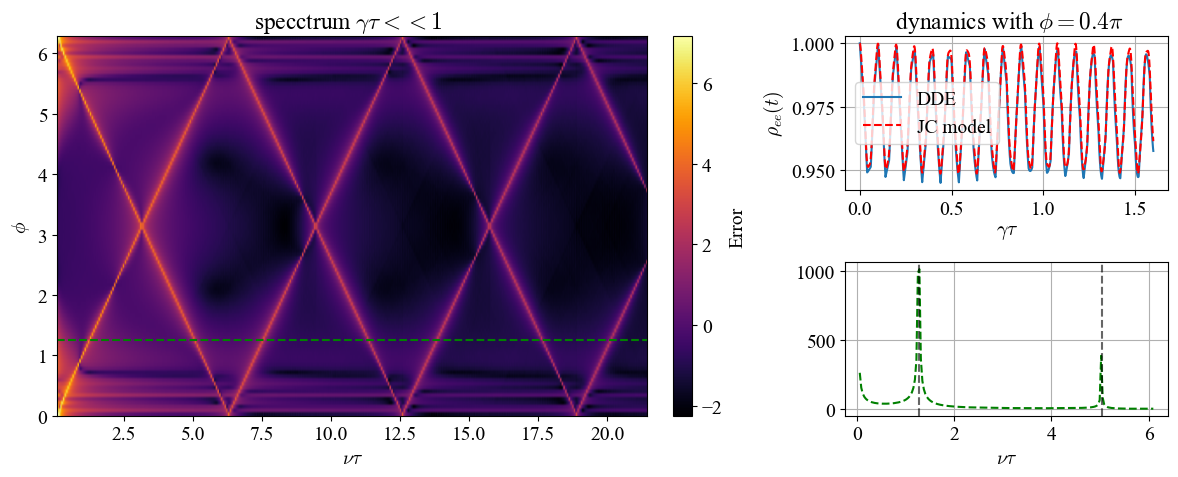

In [ ]:
map_plot = u_map_phi_M[:,3:700]  # not showing all the frequencies, but could. 
tau_s = 1
fig = plt.figure(figsize=(12, 5))

gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1], figure=fig)

#-------------------
ax_heat = fig.add_subplot(gs[:, 0])
im = ax_heat.imshow(
	np.log(map_plot),
	origin='lower',
	aspect='auto',
	extent=[w[3]*tau_s, w[700]*tau_s,phi_values[0], phi_values[-1]],
	cmap='inferno'
)
ax_heat.set_xlabel(r'$  \nu \tau   $')
ax_heat.set_ylabel(r"$ \phi $")
ax_heat.set_title(r'specctrum $ \gamma \tau << 1  $  ')
ax_heat.axhline(phi_3,linestyle = '--',color='g')
cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
cbar.set_label('Error')
#--------------------  
ax_top = fig.add_subplot(gs[0, 1])
ax_top.plot(gamma*t3[0:8000],e3[0:8000],label='DDE')
ax_top.plot(gamma*t3[0:8000],pe3[0:8000],'r--',label='JC model')
ax_top.legend()
ax_top.grid()
ax_top.set_xlabel(r"$\gamma \tau$")
ax_top.set_ylabel(r"$ \rho_{ee}(t)$")
ax_top.set_title(r" dynamics with $\phi = 0.4\pi $")
#--------------------
ax_bottom = fig.add_subplot(gs[1, 1])
ax_bottom.plot(tau*w3[2:200],u3[2:200],'g--')
ax_bottom.axvline(1.27,linestyle='--',color='k',alpha=0.6)
ax_bottom.axvline(5.035,linestyle='--',color='k',alpha=0.6)
ax_bottom.set_xlabel(r"$\nu \tau $")
ax_bottom.grid()

plt.tight_layout()
plt.show()

# 3. Spectrum as a function of $\phi$ with $\gamma \tau >> 1 $ 

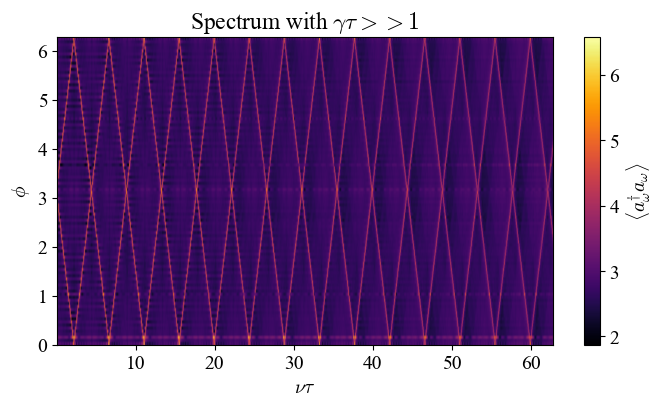

In [89]:
map_plot_2 =u_map_phi[:,3:]
plt.figure(figsize=(8, 4))
plt.imshow(np.log(map_plot_2),
			cmap='inferno',
			origin='lower',
			extent= [ w_phi[3], w_phi[-1],phi_values[0], phi_values[-1]],
			aspect='auto')
plt.colorbar(label=r"$\langle a_{\omega}^{\dag}a_{\omega} \rangle $")
plt.title(r'Spectrum with $\gamma \tau >> 1$')
plt.xlabel(r"$\nu \tau $")
plt.ylabel(r"$ \phi  $")
plt.show()

This shows that the modes in the asymptotic behavior are 
$$ \nu (\phi) = \frac{(2n-1) \pi \pm \phi}{\tau} \Longrightarrow \nu(\omega_{e}) = \omega_{c,n} \pm \omega_{e}$$
That is, the frequencies that appear are the ones from the cavity that couple to the emitter (the odd ones) with a splitting given by the emitter's frequency. 

# Extra graphs 

In [67]:
gamma = 200 
tau  = 1 
phi_1 = 1.2 * np.pi 
phi_2 = 1.91 * np.pi 

t_max = 150*tau
dt = tau/200 

In [68]:
t1,e1,w1,u1 = run_simulation(gamma,tau,phi_1,t_max,dt)

In [69]:
t2,e2,w2,u2 = run_simulation(gamma,tau,phi_2,t_max,dt)

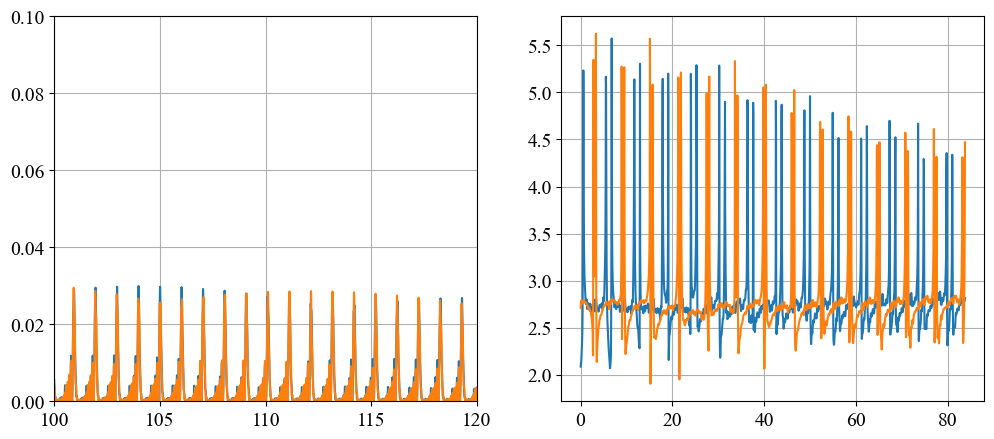

In [76]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

axs[0].plot(t1,e1,)
axs[0].plot(t2,e2)
axs[0].set_xlim(100,120)
axs[0].set_ylim(0,0.1)
axs[0].grid()

axs[1].plot(w1[1:],np.log(u1[1:]))
axs[1].plot(w2[1:],np.log(u2[1:]))
axs[1].grid()

This is interesting. Even when you predict that `different frequencies' interact with the emitter, the population of the emitter is nearly identical regardless of the spectrum 